In [1]:
import gc
import os
import itertools
import pickle
import re
import time
from random import choice, choices
from functools import reduce
from tqdm import tqdm
from itertools import cycle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from functools import reduce
from itertools import cycle
from scipy import stats
from scipy.stats import skew, kurtosis
from sklearn import metrics, model_selection, preprocessing, linear_model, ensemble, decomposition, tree
import lightgbm as lgb
import optuna
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor


import sys
sys.path.append('../../')
from utils import *

## Prepro: change names to numbers

In [2]:
train_feats = pd.read_csv('../../feature_eng/output/train_double_corr_786feats.csv')
train_score = pd.read_csv('../../data/train_scores.csv')

# train_feats_first10min = pd.read_csv('../../feature_eng/output/train_double_corr_first_10min_786feats.csv')
# train_feats_second10min = pd.read_csv('../../feature_eng/output/train_double_corr_second_10min_786feats.csv')
# train_feats = train_feats.merge(train_feats_first10min, on='id', how='left')
# train_feats = train_feats.merge(train_feats_second10min, on='id', how='left')

if 'score' not in train_feats.columns:
    train_feats = pd.merge(train_feats, train_score, on='id', how='left')

train_feats.replace([np.inf, -np.inf], np.nan, inplace=True)
cols = train_feats.columns

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train_feats['score'])

score_transformed = le.transform(train_feats['score'])

## Keep columns

In [3]:
# Options:
# "count_bursts", "word_sent_parag_agg", "pressed_keys", "paussed_features"
# "segments_visit", "paragraph_ratios", "time_gaps", "cursor_word_changes"
# "punctuation", "key_mouse", "time_feat", "fft", "avg_event_per_minute", 
# "avg_char_deletion_per_minute", "avg_char_insert_per_minute"
# "IKI_word", "IKI_sentence", "IKI_paragraph", "latencies", "IWD"

endings_to_keep = ["-count_bursts", "-word_sent_parag_agg"]#, "word_sent_parag_agg", "latencies", "IWD"]
endings_to_keep += ["id"]

dir_to_save = "cat1"
stratification = True
noise = True
iterations = 3
n_splits = 4


# try:
#     os.mkdir(dir_to_save)
# except:
#     print('Already exists')
#     sys.exit()

cols_to_keep = [col for col in train_feats.columns if any(ending in col for ending in endings_to_keep) or col in ['id', 'score']]
# cols_to_keep = [col for col in train_feats.columns if col.endswith(tuple(endings_to_keep)) or col in ['id', 'score']]

# with open(f'{dir_to_save}/feature_list.pkl', 'wb') as f:
#     pickle.dump(cols_to_keep, f)

train_feats = train_feats[cols_to_keep]
print(len(train_feats.columns)-2)

171


In [4]:
counter = 0
new_columns = {}
for col in cols:
    if col != 'id' and col != 'score':
        new_columns[col] = counter
        counter += 1

train_feats.rename(columns=new_columns, inplace=True)

In [5]:
target_col = ['score']
drop_cols = ['id']
train_cols = [col for col in train_feats.columns if col not in target_col + drop_cols]

In [6]:
def objective(trial,train_x,train_y,val_x,val_y,RANDOM_STATE=41):

    params = {
        'iterations': trial.suggest_categorical('iterations', [200, 500, 800, 1000, 1250, 1500]),
        'learning_rate': trial.suggest_float('learning_rate', 5e-6, 5e-2, log=True),
        'depth': trial.suggest_categorical('depth', [5, 7, 9, 11]),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 10.0, log=True),
        # 'bagging_temperature': trial.suggest_float('bagging_temperature', 0.1, 1.0),
        # 'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        # 'max_leaves': trial.suggest_categorical('max_leaves', [8, 16, 25, 31]),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
    }

    all_params = {
        # 'bagging_temperature': 0.5,
        'loss_function': 'RMSE',
        'eval_metric': 'RMSE',
        'random_seed': RANDOM_STATE,
        "task_type": "CPU",
        # "devices": '0:1',
        # 'od_type':"Iter",
        # 'devices': n_jobs,
        # 'silent': False,
        'verbose': 200,
        **params
    }

    model = CatBoostRegressor(**all_params)
    
    model.fit(train_x, train_y)
    
    preds = model.predict(val_x)
    
    rmse = mean_squared_error(val_y, preds, squared=False)
    
    return rmse

In [7]:
def cat_calc_OOF(x_train, y_train, x_valid, y_valid, iter, split, RANDOM_STATE=42, noise=False):
    # split into two validations
    x_valid1, x_valid2, y_valid1, y_valid2 = train_test_split(x_valid, y_valid, test_size=0.5, random_state=RANDOM_STATE, shuffle=False)

    '''Use v1, test on v2'''

    # Bayesian Opt using v1
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, x_train, y_train, x_valid1, y_valid1,RANDOM_STATE), n_trials=20)
    best_trial1 = study.best_trial.params

    # Get best params
    best_params = {
        'bagging_temperature': 0.2,
        'loss_function': 'RMSE',
        'eval_metric': 'RMSE',
        'random_seed': RANDOM_STATE,
        "task_type":"CPU",
        # 'od_type':"Iter",
        # 'devices': n_jobs,
        'silent': True,
        **best_trial1
    }
        
    model = CatBoostRegressor(**best_params)
    if noise:
        y_train = y_train + np.random.normal(0, 0.25, y_train.shape)
    model.fit(x_train, y_train, eval_set=(x_valid1, y_valid1), use_best_model=True, verbose=False)
    model.save_model(f'./{dir_to_save}/cat_iter{iter}_split{split}_val1.model')

    # Predict on v2
    valid2_predict = model.predict(x_valid2)


    '''Use v2, test on v1'''

    # Bayesian Opt using v2
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, x_train, y_train, x_valid2, y_valid2,RANDOM_STATE), n_trials=20)
    best_trial2 = study.best_trial.params

    # Get best params
    best_params = {
        'bagging_temperature': 0.2,
        'loss_function': 'RMSE',
        'eval_metric': 'RMSE',
        # 'od_type':"Iter",
        'random_seed': RANDOM_STATE,
        "task_type": "CPU",
        # 'devices': n_jobs,
        'silent': True,
        **best_trial2
    }
        
    model = CatBoostRegressor(**best_params)
    if noise:
        y_train = y_train + np.random.normal(0, 0.25, y_train.shape)
    model.fit(x_train, y_train, eval_set=(x_valid2, y_valid2), use_best_model=True, verbose=False)
    model.save_model(f'./{dir_to_save}/cat_iter{iter}_split{split}_val2.model')

    # Predict on v1
    valid1_predict = model.predict(x_valid1)

    # Return OOFs
    return np.concatenate([valid1_predict,valid2_predict])

In [8]:
OOF_SCORE = np.zeros(len(train_feats))

models_dict = {}
preds_dict = {}
count = 0
for _ in train_feats['id'].unique():
    preds_dict[count] = []
    count+=1

for i in range(iterations):

    if stratification:
        kf = model_selection.StratifiedKFold(n_splits=n_splits, random_state=41 + i, shuffle=True)
        j = 0
        for fold, (train_idx, valid_idx) in enumerate(kf.split(train_feats, score_transformed)):
            
            X_train, y_train = train_feats.iloc[train_idx][train_cols], train_feats.iloc[train_idx][target_col]
            X_valid, y_valid = train_feats.iloc[valid_idx][train_cols], train_feats.iloc[valid_idx][target_col]

            valid_predict = cat_calc_OOF(X_train, y_train, X_valid, y_valid, i, j, RANDOM_STATE=41 + i)

            OOF_SCORE[valid_idx] += valid_predict / iterations
            j+=1

    else:
        kf = model_selection.KFold(n_splits=n_splits, random_state=41 + i, shuffle=True)
        j = 0
        for fold, (train_idx, valid_idx) in enumerate(kf.split(train_feats)):
            
            X_train, y_train = train_feats.iloc[train_idx][train_cols], train_feats.iloc[train_idx][target_col]
            X_valid, y_valid = train_feats.iloc[valid_idx][train_cols], train_feats.iloc[valid_idx][target_col]

            valid_predict = cat_calc_OOF(X_train, y_train, X_valid, y_valid, i, j, RANDOM_STATE=41 + i)

            OOF_SCORE[valid_idx] += valid_predict / iterations
            j+=1

[I 2024-01-04 18:22:28,473] A new study created in memory with name: no-name-0970379b-7149-4ca9-a01d-cf661e786593


0:	learn: 1.0197316	total: 470ms	remaining: 9m 46s
200:	learn: 0.4761644	total: 1m 2s	remaining: 5m 25s
400:	learn: 0.3057625	total: 2m 3s	remaining: 4m 21s
600:	learn: 0.2105661	total: 3m 3s	remaining: 3m 18s
800:	learn: 0.1483368	total: 4m 3s	remaining: 2m 16s
1000:	learn: 0.0985897	total: 5m 2s	remaining: 1m 15s
1200:	learn: 0.0627672	total: 6m	remaining: 14.7s
1249:	learn: 0.0559203	total: 6m 14s	remaining: 0us


[I 2024-01-04 18:28:44,593] Trial 0 finished with value: 0.6468062020038703 and parameters: {'iterations': 1250, 'learning_rate': 0.00870966864549262, 'depth': 11, 'reg_lambda': 0.0005344663232339152, 'min_data_in_leaf': 59}. Best is trial 0 with value: 0.6468062020038703.


0:	learn: 1.0249245	total: 298ms	remaining: 6m 11s
200:	learn: 0.9150385	total: 59.7s	remaining: 5m 11s
400:	learn: 0.8237835	total: 1m 59s	remaining: 4m 12s
600:	learn: 0.7487087	total: 2m 58s	remaining: 3m 12s
800:	learn: 0.6857007	total: 3m 57s	remaining: 2m 12s
1000:	learn: 0.6327811	total: 4m 56s	remaining: 1m 13s
1200:	learn: 0.5873797	total: 5m 56s	remaining: 14.5s
1249:	learn: 0.5775778	total: 6m 10s	remaining: 0us


[I 2024-01-04 18:34:56,702] Trial 1 finished with value: 0.7216940266116263 and parameters: {'iterations': 1250, 'learning_rate': 0.0009553899268167551, 'depth': 11, 'reg_lambda': 0.0004152218465150781, 'min_data_in_leaf': 72}. Best is trial 0 with value: 0.6468062020038703.


0:	learn: 1.0255137	total: 15.1ms	remaining: 15.1s
200:	learn: 1.0157535	total: 2.47s	remaining: 9.83s
400:	learn: 1.0061971	total: 4.87s	remaining: 7.28s
600:	learn: 0.9968223	total: 7.31s	remaining: 4.85s
800:	learn: 0.9876543	total: 9.75s	remaining: 2.42s


[I 2024-01-04 18:35:09,659] Trial 2 finished with value: 0.9745530782557084 and parameters: {'iterations': 1000, 'learning_rate': 8.846960868338402e-05, 'depth': 7, 'reg_lambda': 0.000342725009822952, 'min_data_in_leaf': 56}. Best is trial 0 with value: 0.6468062020038703.


999:	learn: 0.9786977	total: 12.2s	remaining: 0us
0:	learn: 1.0255439	total: 19ms	remaining: 3.78s


[I 2024-01-04 18:35:12,305] Trial 3 finished with value: 1.0132875830479537 and parameters: {'iterations': 200, 'learning_rate': 3.680379969344466e-05, 'depth': 7, 'reg_lambda': 0.00017438250352521707, 'min_data_in_leaf': 71}. Best is trial 0 with value: 0.6468062020038703.


199:	learn: 1.0214829	total: 2.42s	remaining: 0us
0:	learn: 1.0242927	total: 28ms	remaining: 5.58s


[I 2024-01-04 18:35:15,033] Trial 4 finished with value: 0.8479342139659841 and parameters: {'iterations': 200, 'learning_rate': 0.0021890455912052017, 'depth': 7, 'reg_lambda': 0.07178291224247184, 'min_data_in_leaf': 45}. Best is trial 0 with value: 0.6468062020038703.


199:	learn: 0.8347665	total: 2.51s	remaining: 0us
0:	learn: 1.0242718	total: 80.2ms	remaining: 1m 20s
200:	learn: 0.8294621	total: 8.94s	remaining: 35.5s
400:	learn: 0.7043651	total: 17.8s	remaining: 26.6s
600:	learn: 0.6221265	total: 26.6s	remaining: 17.7s
800:	learn: 0.5649849	total: 36s	remaining: 8.94s


[I 2024-01-04 18:36:00,730] Trial 5 finished with value: 0.6686263301965332 and parameters: {'iterations': 1000, 'learning_rate': 0.0020526053513966786, 'depth': 9, 'reg_lambda': 0.0009092876605605982, 'min_data_in_leaf': 20}. Best is trial 0 with value: 0.6468062020038703.


999:	learn: 0.5223676	total: 44.9s	remaining: 0us
0:	learn: 1.0255503	total: 14.6ms	remaining: 7.27s
200:	learn: 1.0224763	total: 2.55s	remaining: 3.79s
400:	learn: 1.0194203	total: 5.01s	remaining: 1.24s


[I 2024-01-04 18:36:07,292] Trial 6 finished with value: 1.0099347104454157 and parameters: {'iterations': 500, 'learning_rate': 2.9416076532647367e-05, 'depth': 7, 'reg_lambda': 2.3690468212554388, 'min_data_in_leaf': 84}. Best is trial 0 with value: 0.6468062020038703.


499:	learn: 1.0179129	total: 6.23s	remaining: 0us
0:	learn: 1.0255618	total: 11.3ms	remaining: 9.04s
200:	learn: 1.0248447	total: 917ms	remaining: 2.73s
400:	learn: 1.0241247	total: 1.78s	remaining: 1.77s
600:	learn: 1.0234060	total: 2.66s	remaining: 881ms


[I 2024-01-04 18:36:11,318] Trial 7 finished with value: 1.0143276082440724 and parameters: {'iterations': 800, 'learning_rate': 6.837189532384368e-06, 'depth': 5, 'reg_lambda': 0.017394069305921887, 'min_data_in_leaf': 24}. Best is trial 0 with value: 0.6468062020038703.


799:	learn: 1.0226940	total: 3.53s	remaining: 0us
0:	learn: 1.0219647	total: 331ms	remaining: 1m 5s


[I 2024-01-04 18:37:11,631] Trial 8 finished with value: 0.7309873325327314 and parameters: {'iterations': 200, 'learning_rate': 0.005372585179695645, 'depth': 11, 'reg_lambda': 0.0005404593745994829, 'min_data_in_leaf': 34}. Best is trial 0 with value: 0.6468062020038703.


199:	learn: 0.6035271	total: 1m	remaining: 0us
0:	learn: 1.0255617	total: 19.6ms	remaining: 19.5s
200:	learn: 1.0248150	total: 2.48s	remaining: 9.87s
400:	learn: 1.0240684	total: 4.93s	remaining: 7.37s
600:	learn: 1.0233221	total: 7.39s	remaining: 4.91s
800:	learn: 1.0225778	total: 9.94s	remaining: 2.47s


[I 2024-01-04 18:37:24,619] Trial 9 finished with value: 1.0135715707168547 and parameters: {'iterations': 1000, 'learning_rate': 7.04463383907409e-06, 'depth': 7, 'reg_lambda': 1.727602378393079, 'min_data_in_leaf': 91}. Best is trial 0 with value: 0.6468062020038703.


999:	learn: 1.0218367	total: 12.4s	remaining: 0us
0:	learn: 0.9939784	total: 321ms	remaining: 6m 40s
200:	learn: 0.0863608	total: 1m	remaining: 5m 16s
400:	learn: 0.0072594	total: 2m	remaining: 4m 15s
600:	learn: 0.0007279	total: 3m	remaining: 3m 14s
800:	learn: 0.0000824	total: 4m	remaining: 2m 14s
1000:	learn: 0.0000089	total: 5m 1s	remaining: 1m 14s
1200:	learn: 0.0000009	total: 6m 1s	remaining: 14.7s
1249:	learn: 0.0000005	total: 6m 15s	remaining: 0us


[I 2024-01-04 18:43:41,683] Trial 10 finished with value: 0.6575226863861087 and parameters: {'iterations': 1250, 'learning_rate': 0.047530271280103585, 'depth': 11, 'reg_lambda': 0.004763710972113247, 'min_data_in_leaf': 56}. Best is trial 0 with value: 0.6468062020038703.


0:	learn: 0.9941463	total: 297ms	remaining: 6m 10s
200:	learn: 0.0896014	total: 59.9s	remaining: 5m 12s
400:	learn: 0.0088277	total: 1m 59s	remaining: 4m 12s
600:	learn: 0.0008086	total: 2m 58s	remaining: 3m 12s
800:	learn: 0.0000849	total: 3m 58s	remaining: 2m 13s
1000:	learn: 0.0000082	total: 4m 57s	remaining: 1m 14s
1200:	learn: 0.0000010	total: 5m 56s	remaining: 14.5s
1249:	learn: 0.0000006	total: 6m 11s	remaining: 0us


[I 2024-01-04 18:49:54,171] Trial 11 finished with value: 0.6559172328259182 and parameters: {'iterations': 1250, 'learning_rate': 0.04727199608621477, 'depth': 11, 'reg_lambda': 0.004409865871670275, 'min_data_in_leaf': 57}. Best is trial 0 with value: 0.6468062020038703.


0:	learn: 0.9930968	total: 307ms	remaining: 6m 23s
200:	learn: 0.0758539	total: 59.7s	remaining: 5m 11s
400:	learn: 0.0076946	total: 1m 59s	remaining: 4m 12s
600:	learn: 0.0007195	total: 2m 58s	remaining: 3m 12s
800:	learn: 0.0000582	total: 3m 57s	remaining: 2m 13s


[W 2024-01-04 18:54:49,905] Trial 12 failed with parameters: {'iterations': 1250, 'learning_rate': 0.04885126011367453, 'depth': 11, 'reg_lambda': 0.0029680826612179757, 'min_data_in_leaf': 72} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\luis.pinto1\AppData\Local\Temp\ipykernel_2444\3970281857.py", line 9, in <lambda>
    study.optimize(lambda trial: objective(trial, x_train, y_train, x_valid1, y_valid1,RANDOM_STATE), n_trials=20)
  File "C:\Users\luis.pinto1\AppData\Local\Temp\ipykernel_2444\717239885.py", line 30, in objective
    model.fit(train_x, train_y)
  File "c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py", line 5703, in fit
    return self._fit(X, y, cat_features, text_features, embedding_feature

KeyboardInterrupt: 

In [ ]:
print('OOF metric CAT = {:.5f}'.format(metrics.mean_squared_error(train_feats[target_col], 
                                                                   OOF_SCORE/2*3,
                                                                   squared=False)))

OOF metric CAT = 0.61328


In [ ]:
import pickle

with open(f'{dir_to_save}/OOF_base_cat.pkl', 'wb') as f:
    pickle.dump(OOF_SCORE/2*3, f)

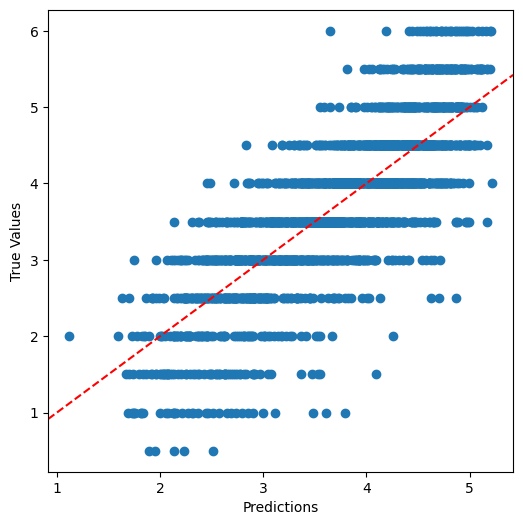

In [ ]:
f, ax = plt.subplots(figsize=(6, 6))
ax.scatter(OOF_SCORE/2*3, train_feats['score'])
add_identity(ax, color='r', ls='--')
# ax.scatter(stds, train_scores_df['score']-means)
plt.ylabel('True Values')
plt.xlabel('Predictions')

plt.show()